In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [18]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150
plt.style.use("paper")

In [3]:
hpr = pd.read_csv("02_data/nequip_hyperparams.csv", index_col=0)
lcv = pd.read_csv("02_data/nequip_learning.csv", index_col=0)
lls = pd.read_csv("02_data/nequip_losslands.csv", index_col=0)
sdf = pd.read_csv("02_data/nequip_entropy.csv", index_col=0)
exp = pd.read_csv("02_data/nequip_explosion.csv", index_col=0)
ext = pd.read_csv("02_data/nequip_extrapolation_errors.csv", index_col=0)

In [4]:
LABELS = {
    "baseline": "no rescaling",
    "non_trainable_bessel": "no Bessel",
    "rescaling": "rescaling + bessel",
}

FIGS_DIR = "04_si"

In [5]:
MODELS = {
    "BIG": ["baseline", "non_trainable_bessel", "rescaling"],
    "2-OPT":  ["2-layer, baseline", "2-layer, AMSGrad-only", "2-layer, EMA-only"],
    "5-OPT":  ["5-layer, baseline", "5-layer, AMSGrad-only", "5-layer, EMA-only"],
    "LAYERS": ["2-layer", "3-layer", "4-layer", "5-layer"],
}

MODELS_ORDER = MODELS["BIG"] + MODELS["2-OPT"] + MODELS["5-OPT"] + MODELS["LAYERS"]

In [6]:
CMAPS = {
    "BIG": cm.Reds_r,
    "2-OPT": cm.Blues_r,
    "5-OPT": cm.Greens_r,
    "LAYERS": cm.Purples_r,
}

In [7]:
_colors = {}
for mset, cases in MODELS.items():
    norm = plt.Normalize(0, len(cases))
    for i, name in enumerate(cases):
        _colors[name] = CMAPS[mset](norm(i))
    
labels = pd.Series(_colors)

In [8]:
def sort_df_by_category(df, key, sorter):
    df = df.copy()
    df["cat"] = df[key].astype("category")
    df["cat"] = df["cat"].cat.set_categories(sorter)
    df = df.sort_values(["cat"]).drop("cat", axis=1)
    
    return df

## Sensitivity analysis of the LLs

In [9]:
def get_entropy(x, T=1e-2, k=1.0):
    y = x
    beta = 1 / (k * T)
    Q = np.sum(np.exp(-beta * y))
    return k * np.log(Q)

In [40]:
_sdf = []

T_F = 4e-2
T_E = 4e-3
ALPHA = 0.2
X_THRESHOLD = 0.025

for T in np.logspace(-3, -1, 1000):
    for model, _df in lls.groupby("model"):    
        Sf = get_entropy(_df["f"].values, T=T)
        Se = get_entropy(_df["e"].values, T=T)

        _subdf = _df.loc[np.abs(_df.x) < X_THRESHOLD]

        _sdf.append({
            "model": model,
            "Se": Se,
            "Sf": Sf,
            "T": T,
        })
    
sdf = pd.DataFrame(_sdf)
perfect_s = get_entropy(np.zeros(81))

webf NOT subset; don't know how to subset; dropped


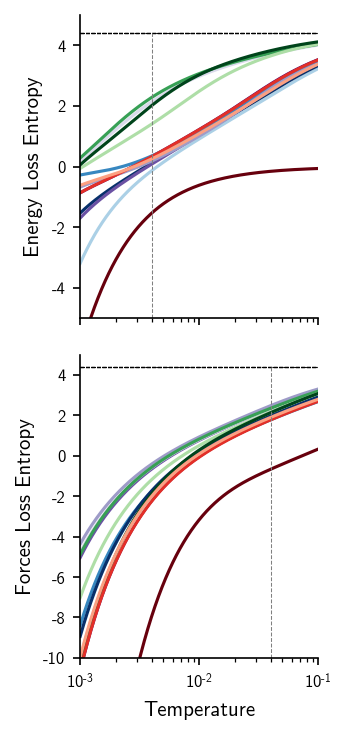

In [58]:
fig, ax_fig = plt.subplots(2, 1, figsize=(2.5, 5), sharex=True)

for ax, qty in zip(ax_fig, ["Se", "Sf"]):
    for model, _df in sdf.groupby("model"):
        color = labels.loc[model]
        ax.plot(_df["T"], _df[qty], color=color, label=model)
        
        ax.plot(
            [1e-3, 1e-1],
            [perfect_s, perfect_s],
            "k--",
            linewidth=0.5,
        )

    ax.set_xscale("log")
    ax.set_xlim(1e-3, 1e-1)

ax_fig[0].set_ylim(-5, 5)
ax_fig[1].set_ylim(-10, 5)

ax_fig[0].set_ylabel("Energy Loss Entropy")
ax_fig[1].set_ylabel("Forces Loss Entropy")
ax_fig[1].set_xlabel("Temperature")

ax_fig[0].plot(
    [4e-3, 4e-3],
    [-5, perfect_s],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax_fig[1].plot(
    [4e-2, 4e-2],
    [-10, perfect_s],
    "--",
    color="#808080",
    linewidth=0.5,
)

# ax_fig[1].legend(frameon=False, fontsize="x-small", bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(f"{FIGS_DIR}/nequip_temperature.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Verifying changes in rank with respect to temperature

,model,Se,Sf,T
3913,2-layer,0.332383,-2.215862,0.004005
3914,"2-layer, AMSGrad-only",0.355509,-1.765021,0.004005
3915,"2-layer, EMA-only",-0.129626,-2.053074,0.004005
3916,"2-layer, baseline",0.127500,-1.724187,0.004005
3917,3-layer,0.087138,-0.651445,0.004005
3918,4-layer,0.187947,-0.406926,0.004005
3919,5-layer,2.145565,-0.582677,0.004005
3920,"5-layer, AMSGrad-only",2.286796,-0.567554,0.004005
3921,"5-layer, EMA-only",1.408313,-1.173958,0.004005
3922,"5-layer, baseline",2.019960,-1.868664,0.004005


In [94]:
_corr = []

T_F = 4e-2
T_E = 4e-3

for T, _df in sdf.groupby("T"):
    _df = _df.set_index("model")
    
    qty = "Se"
    BASE_T = T_E
    base_df = sdf.loc[np.abs(sdf["T"] - BASE_T) == np.abs(sdf["T"] - BASE_T).min()].set_index("model")
    base_df = base_df.sort_values(qty)
    _df = _df.loc[base_df.index]
    e_corr, _ = stats.spearmanr(base_df[qty], _df[qty])

    qty = "Sf"
    BASE_T = T_F
    base_df = sdf.loc[np.abs(sdf["T"] - BASE_T) == np.abs(sdf["T"] - BASE_T).min()].set_index("model")
    base_df = base_df.sort_values(qty)
    _df = _df.loc[base_df.index]
    f_corr, _ = stats.spearmanr(base_df[qty], _df[qty])

    _corr.append({
        "T": T,
        "e_corr": e_corr,
        "f_corr": f_corr,
    })

corr = pd.DataFrame(_corr)

webf NOT subset; don't know how to subset; dropped


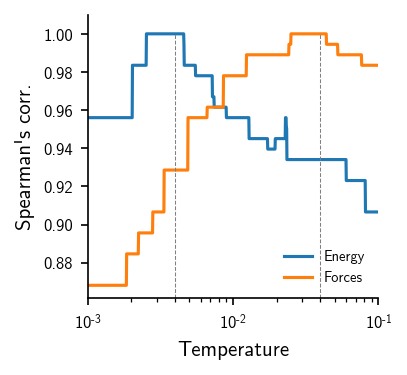

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

ax.plot(corr["T"], corr["e_corr"], label="Energy")
ax.plot(corr["T"], corr["f_corr"], label="Forces")

ax.set_xscale("log")
ax.set_xlim(1e-3, 1e-1)

ax.set_xlabel("Temperature")
ax.set_ylabel("Spearman's corr.")

ymin = ax.get_ylim()[0]
ax.plot(
    [T_E, T_E],
    [ymin, 1],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax.plot(
    [T_F, T_F],
    [ymin, 1],
    "--",
    color="#808080",
    linewidth=0.5,
)

ax.set_ylim(ymin, 1.01)

ax.legend(frameon=False, fontsize="x-small", loc="lower right")
fig.savefig(f"{FIGS_DIR}/nequip_correlation.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Visualizing the LLs and entropy

In [12]:
def get_weighted_energy(x, T=1e-2, k=1):
    beta = 1 / (k * T)
    return np.exp(-beta * x)
    
def get_entropy(x, T=1e-2, k=1.0):
    y = x
    beta = 1 / (k * T)
    Q = np.sum(np.exp(-beta * y))
    return k * np.log(Q)

In [10]:
_df = lls.loc[lls.model == '5-layer']

In [14]:
_df["we"] = _df["e"].apply(lambda x: get_weighted_energy(x, T=4e-3))
_df["wf"] = _df["f"].apply(lambda x: get_weighted_energy(x, T=4e-2))

/tmp/ipykernel_113519/4003605958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["we"] = _df["e"].apply(lambda x: get_weighted_energy(x, T=4e-3))
/tmp/ipykernel_113519/4003605958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["wf"] = _df["f"].apply(lambda x: get_weighted_energy(x, T=4e-2))


In [22]:
_results = []

_df = lls.loc[lls.model == '5-layer']

for T in np.logspace(-3, -1, 10):
    _tmp = _df.copy()
    _tmp["wf"] = _tmp["f"].apply(lambda x: get_weighted_energy(x, T=T))
    _tmp["T"] = T
    _results.append(_tmp)

tdf = pd.concat(_results)

In [23]:
tdf

,model,x,f,e,wf,T
486,5-layer,-0.25000,0.291957,0.249145,1.602439e-127,0.001
487,5-layer,-0.24375,0.283511,0.239439,7.457883e-124,0.001
488,5-layer,-0.23750,0.275410,0.229320,2.460565e-120,0.001
489,5-layer,-0.23125,0.267553,0.218967,6.355724e-117,0.001
490,5-layer,-0.22500,0.259878,0.208518,1.369185e-113,0.001
...,...,...,...,...,...,...
562,5-layer,0.22500,0.454951,0.038203,1.057235e-02,0.100
563,5-layer,0.23125,0.493622,0.042491,7.181664e-03,0.100
564,5-layer,0.23750,0.543831,0.047299,4.346839e-03,0.100
565,5-layer,0.24375,0.611505,0.052802,2.209372e-03,0.100


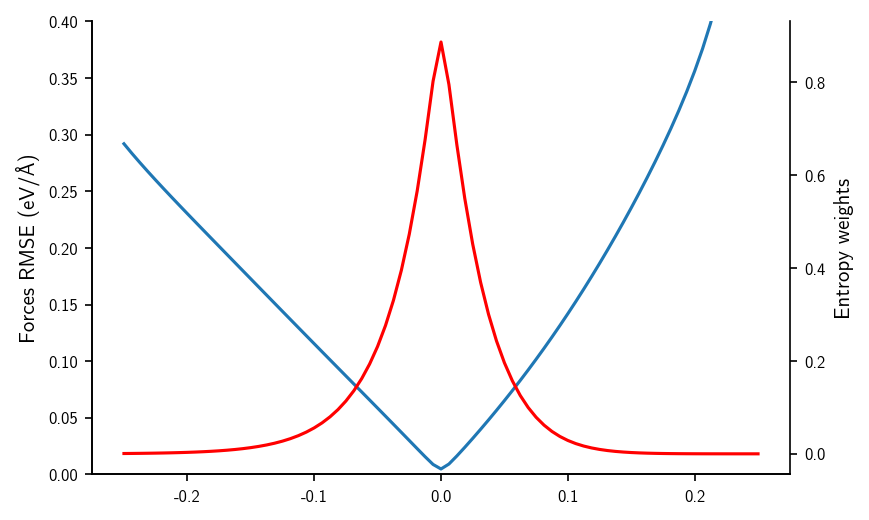

In [19]:
fig, ax = plt.subplots()

_x = _df["x"]
ax.plot(
    _x,
    _df["f"],
)

tax = ax.twinx()

tax.plot(
    _x,
    _df["wf"],
    c="r"
)
ax.spines["right"].set_visible(True)

ax.set_ylabel("Forces RMSE (eV/Å)")
tax.set_ylabel("Entropy weights")

ax.set_ylim(0, 0.4)

plt.show()

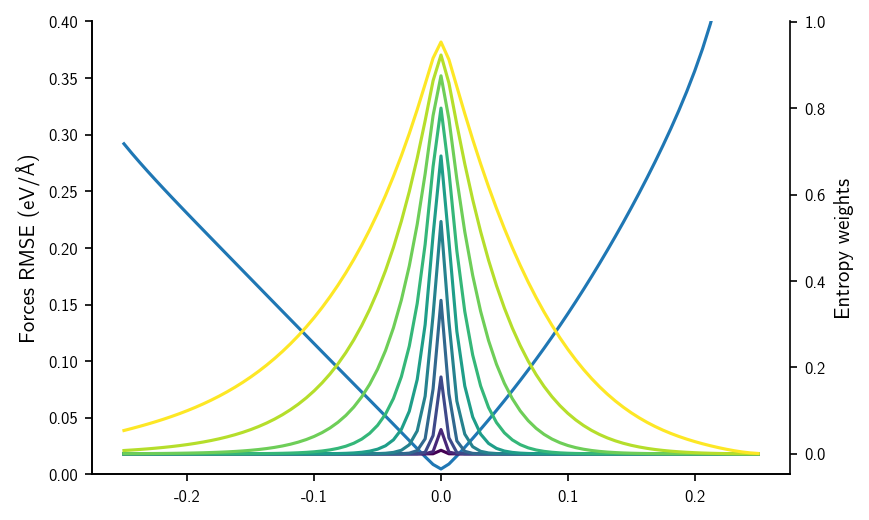

In [27]:
fig, ax = plt.subplots()

_x = _df["x"]

ax.plot(
    _x,
    _df["f"],
)

tax = ax.twinx()

norm = plt.Normalize(-3, -1)
    
for T, _subdf in tdf.groupby("T"):
    _y = _subdf["wf"]
    _y = _y #/ _y.sum()
    tax.plot(
        _x,
        _y,
        c=cm.viridis(norm(np.log10(T)))
    )

ax.spines["right"].set_visible(True)

ax.set_ylabel("Forces RMSE (eV/Å)")
tax.set_ylabel("Entropy weights")

ax.set_ylim(0, 0.4)

plt.show()

## alpha for entropy weights

In [29]:
_results = []

for a in np.linspace(0, 1, 100):
    _tmp = sdf.copy()
    s = a * sdf["Se"] + (1 - a) * sdf["Sf"]
    
    _tmp["S"] = s
    _tmp["a"] = a
    _results.append(_tmp)
    
rdf = pd.concat(_results, axis=0).reset_index()

In [31]:
_corr = []

for a, _subdf in rdf.groupby("a"):
    rho, _ = stats.spearmanr(_subdf["S"], _subdf["explosion_mean"])
    
    _corr.append({
        "a": a,
        "rho": rho,
    })
corr = pd.DataFrame(_corr)

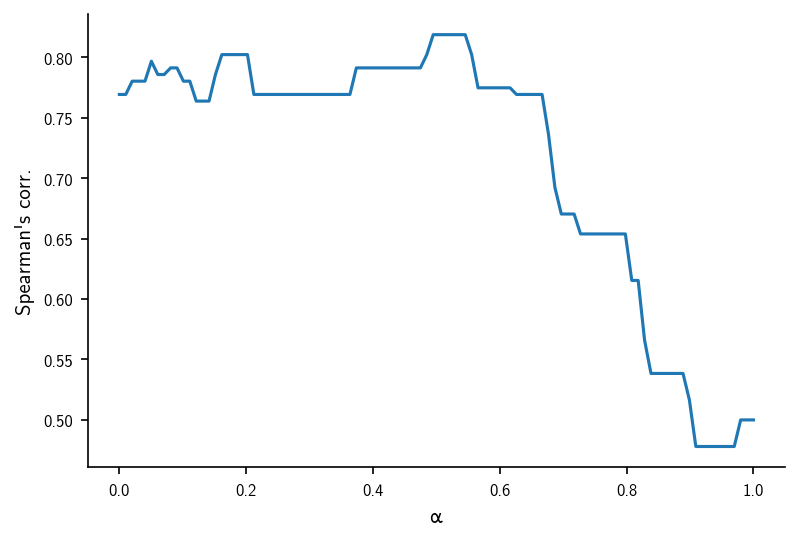

In [36]:
fig, ax = plt.subplots()

ax.plot(corr["a"], corr["rho"])

ax.set_xlabel("$\\alpha$")
ax.set_ylabel("Spearman's corr.")

plt.show()